# Using a Pre-Trained VGG-19 Conv-net to find a peacock

Lets have plots appear inline:

In [1]:
%matplotlib inline

We're going to need `numpy`, `matplotlib`, `skimage`, `theano` and `lasagne`. The `pretrained_vgg_models` contains some useful functions for building and acquiring VGG models.

In [2]:
import os, time
import numpy as np
from matplotlib import pyplot as plt
import theano
import lasagne
import skimage.transform, skimage.util
import pretrained_vgg_models

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer, DropoutLayer, Pool2DLayer, Conv2DLayer, NINLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX


EVIL HACK: Disable cuDNN check


DEBUG: nvcc STDOUT mod.cu
   Creating library D:/temp/theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-2.7.11-64/tmp5e5qt1/265abc51f7c376c224983485238ff1a5.lib and object D:/temp/theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-2.7.11-64/tmp5e5qt1/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: GeForce GTX 970 (CNMeM is enabled with initial size: 25.0% of memory, CuDNN 4007)
d:\packages\theano\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## Load an image to process

In [3]:
IMAGE_PATH = os.path.join('images', 'P1013781.JPG')
original_img = plt.imread(IMAGE_PATH)

The peacock is approximately 900 x 900 pixels in size; about four times too big, so scale the image down by a factor of 4:

In [4]:
img = skimage.transform.rescale(original_img, 1.0 / 4.0, preserve_range=True)

Show it:

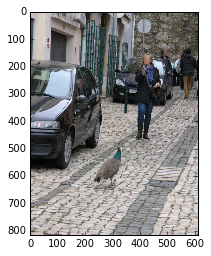

In [5]:
plt.imshow(img.astype('uint8'))
plt.show()

## Load the model

To save some time, we are going to use the `VGG19Model` class from `pretrained_vgg_models` to build the network and load its parameters:

In [6]:
vgg19_model = pretrained_vgg_models.VGG19Model.load()

Create the input variable, generate the probability expression and construct a Theano function that we can call:

In [7]:
in_var = theano.tensor.tensor4('x')
prob = lasagne.layers.get_output(vgg19_model.network['prob'], in_var, deterministic=True)
prob_fn = theano.function([in_var], prob)

This time, prepare the image but *do not* scale and crop, since we want to extract 224x224 regions of the image in a sliding window fashion:

In [8]:
raw_img, img_for_vgg = vgg19_model.prepare_image(img, image_size=None)

Use `skimage.util.view_as_windows` to extract 224 x 224 sliding windows from the image, stepping by 32 pixels. The window shape is `(1,3,224,224)` - 1 sample, 3 channels, 224 x 224 pixels. The step is `(1,3,32,32)`; this will ensure that we will get only one window in the sample and channel dimensions, with as many as needed in the Y and X dimensions.

In [9]:
PRED_STEP = 32

image_windows = skimage.util.view_as_windows(img_for_vgg, (1,3,224,224), (1,3,PRED_STEP,PRED_STEP))
pred_shape = image_windows.shape[2:4]
print image_windows.shape

(1L, 1L, 19L, 13L, 1L, 3L, 224L, 224L)


D:\Anaconda\lib\site-packages\skimage\util\shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


The result is an 8-dimensional array; the dimensions are (sample_window, channel_window, Y_window, X_window, sample, channel, Y, X).

Collapse first 5 dimensions into the sample dimension:

In [10]:
image_windows = image_windows.reshape((-1, 3, 224, 224))
print(image_windows.shape)

(247L, 3L, 224L, 224L)


Lets take a look at a few of the extracted windows:

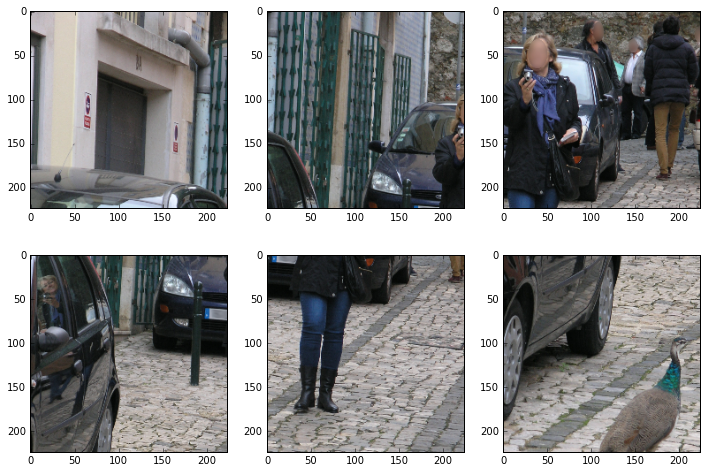

In [11]:
plt.figure(figsize=(12,8))
for i in xrange(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(vgg19_model.inv_prepare_image(image_windows[i*32]))
plt.show()

### Predict probabilities for the 224x224 patches.

Predicting 532 images in one go will use too much GPU memory, so predict them 16 at a time:

In [12]:
t1 = time.time()
pred_prob_flat = [prob_fn(image_windows[i:i+16,:,:,:]) for i in xrange(0, image_windows.shape[0], 16)]
t2 = time.time()
pred_prob_flat = np.concatenate(pred_prob_flat, axis=0)

print('Prediction for {} images took {:.2f}s, resulting in an array of shape{}'.format(image_windows.shape[0],
                                                                                      t2-t1, pred_prob_flat.shape))

Prediction for 247 images took 3.89s, resulting in an array of shape(247L, 1000L)


So we can visualise the predictions, lets reshape the predictions back into two dimensions. The variable `pred_shape` contains the 2D shape of the predicted output:

In [13]:
pred_prob_2d = pred_prob_flat.reshape(pred_shape + (1000,))
print(pred_prob_2d.shape)

(19L, 13L, 1000L)


Use `numpy.argmax` to choose the predicted class and visualise the classes:

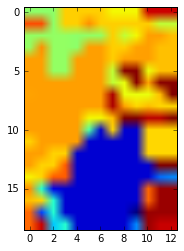

In [14]:
pred_cls_2d = np.argmax(pred_prob_2d, axis=2)
plt.imshow(pred_cls_2d)
plt.show()

Its not easy to interpret, but sort of interesting.
Lets take a look at the image classes that were found in the photo:

In [15]:
# Get the unique values in the `pred_cls_2d` array
classes = np.unique(pred_cls_2d.flatten())

for c in classes:
    # Make a mask that selects the region that has this prediction
    mask_2d = pred_cls_2d == c
    # Select the probabilities chosen by the mask then choose the probability of the chosen class
    prob = pred_prob_2d[mask_2d,:][:,c]
    # Print the class index, name and maximum probability
    print('{}. {}  --  {:.2f}%'.format(c, vgg19_model.class_names[c], np.max(prob) * 100.0))

23. vulture  --  2.13%
84. peacock  --  99.33%
85. quail  --  50.16%
102. echidna, spiny anteater, anteater  --  8.99%
189. Lakeland terrier  --  2.74%
223. schipperke  --  5.72%
245. French bulldog  --  4.29%
298. mongoose  --  9.24%
362. badger  --  3.68%
363. armadillo  --  19.06%
408. amphibian, amphibious vehicle  --  23.65%
468. cab, hack, taxi, taxicab  --  14.43%
471. cannon  --  21.16%
475. car mirror  --  32.40%
523. crutch  --  7.90%
568. fur coat  --  9.94%
575. golfcart, golf cart  --  19.30%
581. grille, radiator grille  --  15.45%
608. jean, blue jean, denim  --  12.15%
609. jeep, landrover  --  34.86%
612. jinrikisha, ricksha, rickshaw  --  42.72%
627. limousine, limo  --  37.99%
630. Loafer  --  9.02%
652. military uniform  --  6.63%
654. minibus  --  42.29%
656. minivan  --  77.57%
670. motor scooter, scooter  --  16.94%
706. patio, terrace  --  14.53%
717. pickup, pickup truck  --  20.16%
734. police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria  -

There are some unlikely choices there; such as '363. armadillo'. Luckily they have low predicted probabilities. Lets isolate the peacock class and visualise:

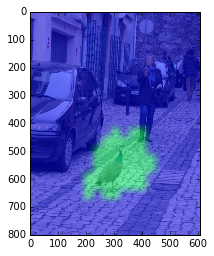

In [16]:
mask_2d = pred_cls_2d == 84  
# One prediction pixel accounts for 32 image pixels. A 224x224 window therefore covers 7 prediction pixels. So put 3px
# padding around the prediction so that we can align it with the original image:
mask_2d = np.pad(mask_2d, [(3, 3), (3, 3)], mode='constant')
# Scale up by a factor of 32 so that we can superimpose the prediction on top of the original:
mask_2d = skimage.transform.rescale(mask_2d, 32)

# SHow it:
plt.imshow(raw_img)
plt.imshow(mask_2d, cmap='winter', alpha=0.5)
plt.show()

## Using convolutions to find the peacock more efficiently

We found the peacock by extracting 224x224 windows from the image in a sliding window fashion and classifying each window individually. This is very wasteful however, as adjacent windows will share most of their input data. We can take advantage of the fact that the network uses convolutions in its earlier layers to run the network against the complete image in one go, generating a 2D prediction 'field', rather than a single prediction.

There is one wrinkle however. The last layers are fully-connected (or dense) layers. These need to be converted to convolutional layers. It turns out that fully-connected layers are equivalent to convolutional layers that take their entire input field and convolve it with a kernel of the same size, resulting in a 1x1 output. In VGG-19, the layer `fc6` takes a 512-channel 7x7 input and converts it to a single 4096-channel output; this is functionally equivalent to a convolutional layer with a 7x7 kernel. Further fully-connected layers that take a single multi-channel input and produce a single multi-channel output can be seen as convolutional layers that take a 1x1 input and produce a 1x1 output, only combining channels with one another. These are functionally equivalent to a convolution with a 1x1 kernel. Such layers are called 'Network-in-Network' [1] layers.

How do we convert a fully-connected layer to a convolutional layer? It turns out that it is rather easy. We need to use the weights and biases in the right way. The biases are easy as we can use them as is; the per-unit biases of a fully connected layer become per channel biases of a convolutional layer. It turns out that the weights are easy too; we can also use them as-is, although a little explanation would be a good idea.

Consider the layer `fc6` from VGG-19. It takes a 512-channel 7x7 input and produces a single 4096-channel output. Each output channel will have 512x7x7 weights; one to modulate each channel of each pixel. Recall that the image array is in the order `(sample, channel, height, width)`. Weights are shared between samples, so the fully-connectd layer does the following:

```
image_flattened = img.reshape((-1, 7*7*512))        # reshape to (sample, channel*height*width)
                                                    # note weights are of shape (channel_in, channel_out)
output = np.dot(image_flattened, weights) + biases  # output shape is (sample, 4096)
```

The input data is in the right order; we just flatten out the last dimensions before the dot-product. What about a convolutional layer? Convolution kernel weights have the shape `(channel_out, channel_in, kernel_height, kernel_width)`. If `kernel_height == height and kernel_width == width` then this is equivalent to:

```
output = np.tensordot(image, kernel_weights, axes=[(1,2,3), (1,2,3)]) + biases[None,:,None,None]
```

The operations are functionally identical. As a consequence we can re-use the weights of the fully-connected layers as convolution kernels with only a axis swap and a reshape operation:

```
conv_weights = np.swap_axes(fc_weights, 1, 0).reshape((512, 7, 7))
```

Lets create a network that will operate in convolutional fashion. To do this, lets derive from the `VGGModel` class, overriding the `build_network` method to define the modified architecture:

In [17]:
def softmax_4d(x):
    # Define a softmax function that will work on 4D tensors
    e_x = np.exp(x - x.max(axis=1)[:, None,:,:])
    return e_x / e_x.sum(axis=1)[:, None,:,:]
    

class VGG19ConvModel (pretrained_vgg_models.VGGModel):
    @classmethod
    def build_network(cls):
        net = {}
        # Input layer: shape is of the form (sample, channel, height, width).
        # We leave the sample dimension with no size (`None`) so that the
        # minibatch size is whatever we need it to be when we use it
        # We get the rest of the size from `img_for_vgg`
        net['input'] = InputLayer((None,) + img_for_vgg.shape[1:])

        # First two convolutional layers: 64 filters, 3x3 convolution, 1 pixel padding
        net['conv1_1'] = Conv2DLayer(net['input'], 64, 3, pad=1, flip_filters=False)
        net['conv1_2'] = Conv2DLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
        # 2x2 max-pooling; will reduce size from 224x224 to 112x112
        net['pool1'] = Pool2DLayer(net['conv1_2'], 2)

        # Two convolutional layers, 128 filters
        net['conv2_1'] = Conv2DLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
        net['conv2_2'] = Conv2DLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
        # 2x2 max-pooling; will reduce size from 112x112 to 56x56
        net['pool2'] = Pool2DLayer(net['conv2_2'], 2)

        # Four convolutional layers, 256 filters
        net['conv3_1'] = Conv2DLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
        net['conv3_2'] = Conv2DLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
        net['conv3_3'] = Conv2DLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
        net['conv3_4'] = Conv2DLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
        # 2x2 max-pooling; will reduce size from 56x56 to 28x28
        net['pool3'] = Pool2DLayer(net['conv3_4'], 2)

        # Four convolutional layers, 512 filters
        net['conv4_1'] = Conv2DLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
        net['conv4_2'] = Conv2DLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
        net['conv4_3'] = Conv2DLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
        net['conv4_4'] = Conv2DLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
        # 2x2 max-pooling; will reduce size from 28x28 to 14x14
        net['pool4'] = Pool2DLayer(net['conv4_4'], 2)

        # Four convolutional layers, 512 filters
        net['conv5_1'] = Conv2DLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
        net['conv5_2'] = Conv2DLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
        net['conv5_3'] = Conv2DLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
        net['conv5_4'] = Conv2DLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
        # 2x2 max-pooling; will reduce size from 14x14 to 7x7
        net['pool5'] = Pool2DLayer(net['conv5_4'], 2)

        ## -- CHANGES HERE --
        
        # Dense layer, 4096 units, 512 channel 7x7 input re-interpreted as a convolutional layer
        net['conv_fc6'] = Conv2DLayer(net['pool5'], 4096, 7)
        # 50% dropout (only applied during training, turned off during prediction)
        net['conv_fc6_dropout'] = DropoutLayer(net['conv_fc6'], p=0.5)

        # Dense layer, 4096 units, re-interpreted as a network-in-network layer
        net['nin_fc7'] = NINLayer(net['conv_fc6_dropout'], num_units=4096)
        # 50% dropout (only applied during training, turned off during prediction)
        net['nin_fc7_dropout'] = DropoutLayer(net['nin_fc7'], p=0.5)

        # Final dense layer, 1000 units: 1 for each class, re-interpreted as a network-in-network layer
        net['nin_fc8'] = NINLayer(net['nin_fc7_dropout'], num_units=1000, nonlinearity=None)
        # Softmax non-linearity that will generate probabilities
        net['prob'] = NonlinearityLayer(net['nin_fc8'], softmax_4d)

        # return the network dictionary and the name of the last layer
        return net, 'prob'    

Instantiate it, transfering parameters from original network:

In [18]:
# Get all the layers from the original model
original_layers = lasagne.layers.get_all_layers(vgg19_model.network[vgg19_model.final_layer_name])
param_values = []
# For each layer:
for layer in original_layers:
    # Get its parameters:
    layer_params = layer.get_params()
    for p in layer_params:
        if layer is vgg19_model.network['fc6'] and p.name == 'W':
            # If we are working on the fc6 layer's weights, we must swap axes and reshape
            # (see explanation further up):
            param_values.append(np.swapaxes(p.get_value(), 1, 0).reshape((4096, 512, 7, 7)))
        else:
            param_values.append(p.get_value())

# Build the new model
vgg19_conv_model = VGG19ConvModel(vgg19_model.mean_value, vgg19_model.class_names, 'VGG-19-conv', param_values)

Build theano functions for the new network, re-using the old input variable:

In [19]:
prob_conv = lasagne.layers.get_output(vgg19_conv_model.network['prob'], in_var, deterministic=True)
prob_conv_fn = theano.function([in_var], prob_conv)

Now predict and time it:

In [20]:
t1 = time.time()
pred_prob_conv = prob_conv_fn(img_for_vgg)
t2 = time.time()

print('Prediction for {} images took {:.2f}s, resulting in an array of shape{}'.format(img_for_vgg.shape,
                                                                                      t2-t1, pred_prob_conv.shape))

Prediction for (1L, 3L, 816L, 612L) images took 0.22s, resulting in an array of shape(1L, 1000L, 19L, 13L)


#### ^^^ *NOTE THE >10x speedup and that everything fit into RAM* ^^^

Compute the predicted classes using `numpy.argmax`:

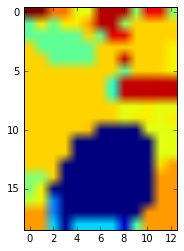

In [21]:
pred_cls_conv = np.argmax(pred_prob_conv[0,:,:,:], axis=0)
plt.imshow(pred_cls_conv)
plt.show()

The results aren't identical.

Find the peacock once again:

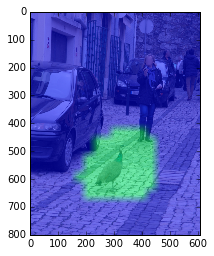

In [22]:
mask_2d = pred_cls_conv == 84  
# One prediction pixel accounts for 32 image pixels. A 224x224 window therefore covers 7 prediction pixels. So put 3px
# padding around the prediction so that we can align it with the original image:
mask_2d = np.pad(mask_2d, [(3, 3), (3, 3)], mode='constant')
# Scale up by a factor of 32 so that we can superimpose the prediction on top of the original:
mask_2d = skimage.transform.rescale(mask_2d, 32)

# SHow it:
plt.imshow(raw_img)
plt.imshow(mask_2d, cmap='winter', alpha=0.5)
plt.show()

Let's see what we found:

In [23]:
# Get the unique values in the `pred_cls_2d` array
classes = np.unique(pred_cls_conv.flatten())

for c in classes:
    # Make a mask that selects the region that has this prediction
    mask_2d = pred_cls_conv == c
    # Select the probabilities chosen by the mask then choose the probability of the chosen class
    prob = pred_prob_conv[0][:,mask_2d][c,:]
    # Print the class index, name and maximum probability
    print('{}. {}  --  {:.2f}%'.format(c, vgg19_model.class_names[c], np.max(prob) * 100.0))

84. peacock  --  99.66%
99. goose  --  10.16%
144. pelican  --  6.00%
298. mongoose  --  9.18%
363. armadillo  --  11.72%
414. backpack, back pack, knapsack, packsack, rucksack, haversack  --  6.67%
460. breakwater, groin, groyne, mole, bulwark, seawall, jetty  --  4.52%
466. bullet train, bullet  --  7.90%
468. cab, hack, taxi, taxicab  --  5.29%
475. car mirror  --  37.76%
511. convertible  --  21.59%
523. crutch  --  5.65%
575. golfcart, golf cart  --  5.25%
608. jean, blue jean, denim  --  15.72%
612. jinrikisha, ricksha, rickshaw  --  9.27%
627. limousine, limo  --  11.76%
630. Loafer  --  13.04%
637. mailbox, letter box  --  14.25%
646. maze, labyrinth  --  3.61%
654. minibus  --  3.54%
655. miniskirt, mini  --  9.37%
656. minivan  --  67.43%
670. motor scooter, scooter  --  8.48%
704. parking meter  --  12.21%
706. patio, terrace  --  19.40%
743. prison, prison house  --  7.39%
837. sunglasses, dark glasses, shades  --  5.93%
843. swing  --  7.72%
869. trench coat  --  17.60%
87

## References

[1] Lin, Min, Qiang Chen, and Shuicheng Yan. "Network in network." arXiv preprint arXiv:1312.4400 (2013).